In [1]:
import numpy as np
import pandas as pd
import cv2
import os
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.metrics import AUC
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications import ResNet50, DenseNet121
import tensorflow as tf
import sklearn

In [7]:
csv_file_path = '../DL_for_Hin_Chest_X_Ray/Data_Entry_2017_filtered_2.csv'
# csv_file_path = '../DL_for_Hin_Chest_X_Ray/HIN_archive/Data_Entry_2017.csv'
df = pd.read_csv(csv_file_path)

IMAGE_DIR = "../DL_for_Hin_Chest_X_Ray/HIN_archive/images/"
ALL_LABELS = sorted(df["Finding Labels"].str.split("|").explode().unique())
ALL_LABELS_WITHOUT_NO = [l for l in ALL_LABELS if l != "No Finding"]
NUMBER_CLASSES = len(ALL_LABELS)

def preprocess_image(file_path, image_size):
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        return None
    image = cv2.resize(image, (image_size, image_size))
    return image

def prepare_data(df, image_size, image_dir=IMAGE_DIR):
    images = []
    labels = []
    
    for _, row in tqdm(df.iterrows(), total=len(df)):
        image_path = os.path.join(image_dir, row["Image Index"])
        image = preprocess_image(image_path, image_size)
        
        if image is not None:
            images.append(image)

            current_label = np.zeros(NUMBER_CLASSES, dtype=int)
        
            if row["Finding Labels"] != "No Finding":
                indices = [i for i, label in enumerate(ALL_LABELS_WITHOUT_NO) if label in sorted(row["Finding Labels"].split("|"))]
                for idx in indices:
                    if 0 <= idx < NUMBER_CLASSES:
                        current_label[idx] = 1
            else:
                current_label[NUMBER_CLASSES - 1] = 1
            labels.append(current_label)
    
    images = np.array(images).reshape(-1, image_size, image_size)
    images = np.repeat(images[..., np.newaxis], 3, axis=-1) #rgb
    
    labels = np.array(labels)
    
    return images, labels

In [8]:
def create_resnet_model(image_size):
    base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(image_size, image_size, 3), pooling=None)
    base_model.trainable = False
    
    model = Sequential()
    model.add(base_model)
    model.add(Conv2D(2048, (1, 1), activation='relu')) # Transition Layer
    model.add(GlobalAveragePooling2D())   
    model.add(Dense(NUMBER_CLASSES, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[AUC(multi_label=True)])
    return model

In [9]:
def normalize_image(img, label):
    img = tf.cast(img, np.float32)# / 255.0
    img = tf.keras.applications.resnet.preprocess_input(img)
    return img, label

def create_train_dataset(images_train, labels_train, batch_size=16):
    train_dataset = tf.data.Dataset.from_tensor_slices((images_train, labels_train))
    train_dataset = train_dataset.map(normalize_image)
    train_dataset = train_dataset.shuffle(buffer_size=100)
    train_dataset = train_dataset.batch(batch_size, drop_remainder=True)
    train_dataset = train_dataset.repeat()
    return train_dataset

def create_val_dataset(images_val, labels_val, batch_size=16):
    val_dataset = tf.data.Dataset.from_tensor_slices((images_val, labels_val))
    val_dataset = val_dataset.map(normalize_image)
    val_dataset = val_dataset.batch(batch_size, drop_remainder=False)
    return val_dataset

In [10]:
def evaluate_model_2(model, images_test, labels_test, batch_size=16, num_steps=10):
    
    total_samples = len(images_test) 
    step_size = total_samples // num_steps  # Size of each step
    auc_per_class = [0] * NUMBER_CLASSES
    
    for step in range(num_steps):
        start_idx = step * step_size
        end_idx = min((step + 1) * step_size, total_samples)
        
        images_batch = images_test[start_idx:end_idx]
        labels_batch = labels_test[start_idx:end_idx]
        
        # images_batch_2 = tf.cast(images_batch, np.float32) / 255.0
        
        images_batch_2 = []
        for sample in images_batch:
            images_batch_2.append(normalize_image(sample, None)) 
        images_batch_2 = np.array([tensor[0].numpy() for tensor in images_batch_2])

        predictions_batch = model.predict(images_batch_2, batch_size=batch_size)
        
        for class_idx in range(NUMBER_CLASSES):
            true_labels_class = labels_batch[:, class_idx]
            
            auc = sklearn.metrics.roc_auc_score(true_labels_class, predictions_batch[:, class_idx])
            print(auc)
            auc_per_class[class_idx] += auc
            
    auc_per_class = [auc / num_steps for auc in auc_per_class]
    
    return auc_per_class, 0, 0

In [ ]:
MAX_NUMBER_IMAGES = 73142

In [6]:
IMAGE_SIZE = 224
BATCH_SIZE = 16
MODEL_PATH = 'modelsAmount/resnet_11/'
MAX_NUMBER_IMAGES = 40000
evaluations = {}

df = df.sample(frac=1, random_state=42).reset_index(drop=True)

images, labels = prepare_data(df[:MAX_NUMBER_IMAGES], IMAGE_SIZE)
images_test, labels_test = prepare_data(df[-(int(MAX_NUMBER_IMAGES / 5)):], IMAGE_SIZE)

with open(f"{MODEL_PATH}images.pkl", "wb") as file:
    pickle.dump(images, file)
with open(f"{MODEL_PATH}labels.pkl", "wb") as file:
    pickle.dump(labels, file)
with open(f"{MODEL_PATH}images_test.pkl", "wb") as file:
    pickle.dump(images_test, file)
with open(f"{MODEL_PATH}labels_test.pkl", "wb") as file:
    pickle.dump(labels_test, file)

 69%|██████▉   | 27666/40000 [05:39<02:31, 81.60it/s]


KeyboardInterrupt: 

In [6]:
IMAGE_SIZE = 224
BATCH_SIZE = 16
MODEL_PATH = 'modelsAmount/resnet_11/'
MAX_NUMBER_IMAGES = 40000
evaluations = {}


with open(f"{MODEL_PATH}images.pkl", "rb") as file:
    images = pickle.load(file)
with open(f"{MODEL_PATH}labels.pkl", "rb") as file:
    labels = pickle.load(file)
with open(f"{MODEL_PATH}images_test.pkl", "rb") as file:
    images_test = pickle.load(file)
with open(f"{MODEL_PATH}labels_test.pkl", "rb") as file:
    labels_test = pickle.load(file)

In [16]:
IMAGE_SIZE = 224
BATCH_SIZE = 16
MODEL_PATH = 'modelsAmount/resnet_11/'
MAX_NUMBER_IMAGES = 40000

In [17]:
master_evaluations = {}

for run in range(1, 6):
    
    evaluations = {}
    
    MODEL_PATH = f'modelsAmount/resnet_1{run}/'
    
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    
    images, labels = prepare_data(df[:MAX_NUMBER_IMAGES], IMAGE_SIZE)
    images_test, labels_test = prepare_data(df[-(int(MAX_NUMBER_IMAGES / 5)):], IMAGE_SIZE)
    
    with open(f"{MODEL_PATH}images.pkl", "wb") as file:
        pickle.dump(images, file)
    with open(f"{MODEL_PATH}labels.pkl", "wb") as file:
        pickle.dump(labels, file)
    with open(f"{MODEL_PATH}images_test.pkl", "wb") as file:
        pickle.dump(images_test, file)
    with open(f"{MODEL_PATH}labels_test.pkl", "wb") as file:
        pickle.dump(labels_test, file)
    
    # with open(f"{MODEL_PATH}images.pkl", "rb") as file:
    #     images = pickle.load(file)
    # with open(f"{MODEL_PATH}labels.pkl", "rb") as file:
    #     labels = pickle.load(file)
    # with open(f"{MODEL_PATH}images_test.pkl", "rb") as file:
    #     images_test = pickle.load(file)
    # with open(f"{MODEL_PATH}labels_test.pkl", "rb") as file:
    #     labels_test = pickle.load(file)

    for amount in [1000, 5000, 10000, 20000, 30000, 40000]:
        tf.keras.backend.clear_session()
    
        images_train, images_val, labels_train, labels_val = sklearn.model_selection.train_test_split(images[:amount], labels[:amount], random_state=42, test_size=0.2)
       
        train_dataset = create_train_dataset(images_train, labels_train)
        val_dataset = create_val_dataset(images_val, labels_val)
            
        steps_per_epoch = len(images_train) // BATCH_SIZE
        validation_steps = len(images_val) // BATCH_SIZE
        
        model = create_resnet_model(IMAGE_SIZE)
    
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        
        history = model.fit(
            images_train,
            labels_train,
            steps_per_epoch=steps_per_epoch,
            epochs=20,
            validation_data=(images_val, labels_val),
            validation_steps=validation_steps,
            callbacks=[early_stopping]
        )
        
        model.save(MODEL_PATH + str(amount) + '_final.keras')
        
        evals = evaluate_model_2(model, images_test, labels_test) # fix
        evaluations[amount] = evals
        print(amount)
        print(evaluations)
        
        with open(f"{MODEL_PATH}evaluations.pkl", "wb") as file:
            pickle.dump(evaluations, file)
                    
    print(evaluations)
    master_evaluations[run] = evaluations
    
print(master_evaluations)


100%|██████████| 8000/8000 [01:39<00:00, 80.49it/s]


Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 181ms/step - auc: 0.5487 - loss: 2.9856 - val_auc: 0.6821 - val_loss: 0.7915
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - auc: 0.8012 - loss: 0.7619 - val_auc: 0.6915 - val_loss: 0.8214
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - auc: 0.8800 - loss: 0.6107 - val_auc: 0.6850 - val_loss: 0.8146
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - auc: 0.9153 - loss: 0.5122 - val_auc: 0.6978 - val_loss: 0.8652
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - auc: 0.9588 - loss: 0.3888 - val_auc: 0.7108 - val_loss: 0.9631
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - auc: 0.9872 - loss: 0.2454 - val_auc: 0.6665 - val_loss: 0.9894
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step
0.7104543639212314
0.7466741785402733
0.5511889430289834
0.6778079376763587
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step
0.6776540122755172
0.7375526380975972
0.6358812857289563
0.6881672727272728
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step
0.685117464539007
0

/Users/I569354/Library/Caches/pypoetry/virtualenvs/medicaldeeplearning-6tfcUi4t-py3.10/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


250/250 ━━━━━━━━━━━━━━━━━━━━ 34s 123ms/step - auc: 0.6155 - loss: 1.9938 - val_auc: 0.7181 - val_loss: 0.8430
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 28s 111ms/step - auc: 0.7479 - loss: 0.8008 - val_auc: 0.7205 - val_loss: 0.9149
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 28s 111ms/step - auc: 0.7846 - loss: 0.7928 - val_auc: 0.7190 - val_loss: 0.8993
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 28s 111ms/step - auc: 0.8447 - loss: 0.6797 - val_auc: 0.6773 - val_loss: 0.9691
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 28s 112ms/step - auc: 0.9044 - loss: 0.5583 - val_auc: 0.6927 - val_loss: 0.9461
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 28s 111ms/step - auc: 0.9447 - loss: 0.4458 - val_auc: 0.6624 - val_loss: 0.9941
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step
0.6764154711068784
0.7933992439662693
0.5933828117739216
0.6902182247576985
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step
0.6802808719153343
0.7506605565188671
0.6607788769839912
0.6941309090909091
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step
0.70340203900

100%|██████████| 8000/8000 [01:41<00:00, 78.73it/s]


Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 183ms/step - auc: 0.5180 - loss: 4.2692 - val_auc: 0.6514 - val_loss: 0.9311
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - auc: 0.7484 - loss: 0.8322 - val_auc: 0.6360 - val_loss: 0.9436
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - auc: 0.8180 - loss: 0.6907 - val_auc: 0.6523 - val_loss: 1.1048
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - auc: 0.8655 - loss: 0.6521 - val_auc: 0.6370 - val_loss: 1.0090
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - auc: 0.9293 - loss: 0.4735 - val_auc: 0.6402 - val_loss: 1.2195
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - auc: 0.9583 - loss: 0.4213 - val_auc: 0.6261 - val_loss: 1.2689
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step
0.673356637737062
0.7196239151398265
0.5956801084815807
0.6748900746181086
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step
0.6517379679144385
0.7074175824175825
0.5727226503960607
0.6227613525983486
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step
0.6728969559851914
0

/Users/I569354/Library/Caches/pypoetry/virtualenvs/medicaldeeplearning-6tfcUi4t-py3.10/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


250/250 ━━━━━━━━━━━━━━━━━━━━ 36s 127ms/step - auc: 0.6207 - loss: 1.5373 - val_auc: 0.7168 - val_loss: 0.9363
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 28s 113ms/step - auc: 0.7344 - loss: 0.8476 - val_auc: 0.7236 - val_loss: 0.8973
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 28s 113ms/step - auc: 0.7971 - loss: 0.7473 - val_auc: 0.7266 - val_loss: 0.8981
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 28s 112ms/step - auc: 0.8447 - loss: 0.6941 - val_auc: 0.7143 - val_loss: 1.0063
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 28s 112ms/step - auc: 0.9128 - loss: 0.5195 - val_auc: 0.6984 - val_loss: 0.9975
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 28s 112ms/step - auc: 0.9590 - loss: 0.3859 - val_auc: 0.6439 - val_loss: 1.1103
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 28s 112ms/step - auc: 0.9832 - loss: 0.2402 - val_auc: 0.6818 - val_loss: 1.2914
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step
0.6606195756991321
0.6965204114432658
0.6473057178833177
0.6956188609176439
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step
0.657394

100%|██████████| 8000/8000 [01:40<00:00, 79.33it/s]


Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 199ms/step - auc: 0.5260 - loss: 3.5761 - val_auc: 0.6880 - val_loss: 0.8798
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step - auc: 0.7392 - loss: 0.8844 - val_auc: 0.6684 - val_loss: 0.9323
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 117ms/step - auc: 0.8126 - loss: 0.7241 - val_auc: 0.6777 - val_loss: 0.9325
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - auc: 0.8885 - loss: 0.6433 - val_auc: 0.6639 - val_loss: 0.9515
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - auc: 0.9274 - loss: 0.5493 - val_auc: 0.6532 - val_loss: 1.0064
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step - auc: 0.9568 - loss: 0.3644 - val_auc: 0.5834 - val_loss: 1.2071
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step
0.6316004224270353
0.7694896551724137
0.6042206235011991
0.6893632047121049
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step
0.6406696418030271
0.7528932166386523
0.6289811078616468
0.7023449568419589
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step
0.6592052135722888


/Users/I569354/Library/Caches/pypoetry/virtualenvs/medicaldeeplearning-6tfcUi4t-py3.10/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


250/250 ━━━━━━━━━━━━━━━━━━━━ 36s 129ms/step - auc: 0.5714 - loss: 2.3577 - val_auc: 0.6948 - val_loss: 0.8888
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 28s 113ms/step - auc: 0.7429 - loss: 0.8113 - val_auc: 0.6983 - val_loss: 0.9161
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 28s 112ms/step - auc: 0.7835 - loss: 0.7450 - val_auc: 0.7083 - val_loss: 0.9139
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 28s 113ms/step - auc: 0.8386 - loss: 0.6874 - val_auc: 0.6983 - val_loss: 0.9029
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 28s 112ms/step - auc: 0.8981 - loss: 0.5617 - val_auc: 0.6898 - val_loss: 1.0102
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 28s 112ms/step - auc: 0.9324 - loss: 0.4738 - val_auc: 0.6789 - val_loss: 1.0611
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step
0.6860599078341013
0.8052597701149425
0.6052689277149709
0.6924209640581801
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step
0.7092630634459635
0.8056183465677468
0.6297338318587347
0.7343309588479475
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step
0.70848386106

100%|██████████| 8000/8000 [01:39<00:00, 80.21it/s]


Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 208ms/step - auc: 0.5309 - loss: 4.4537 - val_auc: 0.6760 - val_loss: 0.8251
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step - auc: 0.7804 - loss: 0.7910 - val_auc: 0.6643 - val_loss: 0.8152
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - auc: 0.8509 - loss: 0.7000 - val_auc: 0.6051 - val_loss: 0.9881
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - auc: 0.8412 - loss: 0.6641 - val_auc: 0.6345 - val_loss: 0.9962
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - auc: 0.9536 - loss: 0.4458 - val_auc: 0.6465 - val_loss: 0.9646
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - auc: 0.9732 - loss: 0.3165 - val_auc: 0.6112 - val_loss: 1.0258
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - auc: 0.9856 - loss: 0.2840 - val_auc: 0.6099 - val_loss: 1.1539
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step
0.6959540632444869
0.7393094390139173
0.5930479016532428
0.689237181180476
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step
0.7220988407565588

/Users/I569354/Library/Caches/pypoetry/virtualenvs/medicaldeeplearning-6tfcUi4t-py3.10/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


250/250 ━━━━━━━━━━━━━━━━━━━━ 37s 130ms/step - auc: 0.6074 - loss: 1.6839 - val_auc: 0.7095 - val_loss: 0.9007
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 28s 113ms/step - auc: 0.7303 - loss: 0.8540 - val_auc: 0.7126 - val_loss: 0.8639
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 28s 112ms/step - auc: 0.7986 - loss: 0.7662 - val_auc: 0.7065 - val_loss: 0.8837
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 28s 112ms/step - auc: 0.8434 - loss: 0.6907 - val_auc: 0.6887 - val_loss: 0.9933
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 28s 112ms/step - auc: 0.8934 - loss: 0.5832 - val_auc: 0.6886 - val_loss: 0.9613
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 28s 112ms/step - auc: 0.9540 - loss: 0.4192 - val_auc: 0.6718 - val_loss: 1.1678
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 28s 112ms/step - auc: 0.9781 - loss: 0.2775 - val_auc: 0.6484 - val_loss: 1.2540
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step
0.6866282502901591
0.7915435326210503
0.568225707691583
0.6869184937336738
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step
0.7086516

100%|██████████| 8000/8000 [01:39<00:00, 80.69it/s]


Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 234ms/step - auc: 0.5619 - loss: 3.1704 - val_auc: 0.6777 - val_loss: 0.8882
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - auc: 0.7474 - loss: 0.8514 - val_auc: 0.7126 - val_loss: 0.8392
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step - auc: 0.8394 - loss: 0.7595 - val_auc: 0.7173 - val_loss: 0.8513
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - auc: 0.8901 - loss: 0.5630 - val_auc: 0.7172 - val_loss: 0.9035
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - auc: 0.9613 - loss: 0.4413 - val_auc: 0.7191 - val_loss: 0.9643
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - auc: 0.9829 - loss: 0.2774 - val_auc: 0.6938 - val_loss: 1.2037
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - auc: 0.9895 - loss: 0.2458 - val_auc: 0.6935 - val_loss: 1.1348
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step
0.6963955162484574
0.6753113553113553
0.5851282665244506
0.680951286764706
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step
0.6905154585198565

/Users/I569354/Library/Caches/pypoetry/virtualenvs/medicaldeeplearning-6tfcUi4t-py3.10/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


250/250 ━━━━━━━━━━━━━━━━━━━━ 38s 135ms/step - auc: 0.5998 - loss: 1.8799 - val_auc: 0.7141 - val_loss: 0.9213
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 30s 121ms/step - auc: 0.7286 - loss: 0.8586 - val_auc: 0.7233 - val_loss: 0.9089
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 30s 121ms/step - auc: 0.7896 - loss: 0.8098 - val_auc: 0.7285 - val_loss: 0.8838
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 30s 120ms/step - auc: 0.8512 - loss: 0.6946 - val_auc: 0.7158 - val_loss: 0.9685
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 30s 120ms/step - auc: 0.8983 - loss: 0.5871 - val_auc: 0.6820 - val_loss: 1.0282
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 30s 120ms/step - auc: 0.9507 - loss: 0.4128 - val_auc: 0.6817 - val_loss: 1.1275
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 30s 121ms/step - auc: 0.9788 - loss: 0.2899 - val_auc: 0.6767 - val_loss: 1.2194
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 31s 122ms/step - auc: 0.9953 - loss: 0.1603 - val_auc: 0.6512 - val_loss: 1.4521
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 86ms/step
0.6

In [ ]:

# for amount in [44000]:

for amount in [1000, 5000, 10000, 20000, 30000, 40000, 50000]:
    tf.keras.backend.clear_session()

    images_train, images_val, labels_train, labels_val = sklearn.model_selection.train_test_split(images[:amount], labels[:amount], random_state=42, test_size=0.2)
   
    train_dataset = create_train_dataset(images_train, labels_train)
    val_dataset = create_val_dataset(images_val, labels_val)
        
    steps_per_epoch = len(images_train) // BATCH_SIZE
    validation_steps = len(images_val) // BATCH_SIZE
    
    model = create_resnet_model(IMAGE_SIZE)

    early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    
    history = model.fit(
        train_dataset,
        steps_per_epoch=steps_per_epoch,
        epochs=100,
        validation_data=val_dataset,
        validation_steps=validation_steps,
        callbacks=[early_stopping]
    )
    
    model.save(MODEL_PATH + str(amount) + '_final.keras')
    
    evals = evaluate_model_2(model, images_test, labels_test) # fix
    evaluations[amount] = evals
    print(evaluations)
    
    with open(f"{MODEL_PATH}history{amount}.pkl", "wb") as file:
        pickle.dump(history, file)

    with open(f"{MODEL_PATH}evaluations.pkl", "wb") as file:
        pickle.dump(evaluations, file)
        
print(evaluations)

2025-03-18 09:09:56.024289: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-03-18 09:09:56.024406: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-03-18 09:09:56.024425: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-03-18 09:09:56.024823: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-18 09:09:56.025404: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/100


2025-03-18 09:09:58.857670: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 176ms/step - auc: 0.4854 - loss: 1.5016 - val_auc: 0.5070 - val_loss: 1.1117
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - auc: 0.4995 - loss: 1.0222 - val_auc: 0.5183 - val_loss: 1.1662
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - auc: 0.4912 - loss: 1.0846 - val_auc: 0.5087 - val_loss: 1.1317
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - auc: 0.5194 - loss: 0.9960 - val_auc: 0.5170 - val_loss: 1.2465
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - auc: 0.4931 - loss: 1.0531 - val_auc: 0.5075 - val_loss: 1.1005
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 117ms/step - auc: 0.5012 - loss: 1.0174 - val_auc: 0.5194 - val_loss: 1.0786
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - auc: 0.5338 - loss: 1.0031 - val_auc: 0.5165 - val_loss: 1.0856
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step - auc: 0.5441 - loss: 0.9881 - val_auc: 0.5146 - val_loss: 1.1227
Epoch 9/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - auc:

In [2]:
# Fixed normalize image


evaluations11 = {1000: ([0.6830071946578448, 0.7261172943785704, 0.6000307570126673, 0.6752040589116775], 0, 0), 5000: ([0.7049029257301231, 0.7777281530391658, 0.6227892485675411, 0.6978763998995426], 0, 0), 10000: ([0.7104698145225916, 0.7834703457219989, 0.6244056262975911, 0.694786292954141], 0, 0), 20000: ([0.7177856700050378, 0.7972485046301556, 0.6241148939920895, 0.6956901071130706], 0, 0), 30000: ([0.7091774941892501, 0.7945847042029824, 0.6403856928329402, 0.7067685809173356], 0, 0), 40000: ([0.7278121244599983, 0.7930063863784174, 0.6440166650463237, 0.7054722805319089], 0, 0)}
evaluations12 = {1000: ([0.6590524623219987, 0.7058752065293801, 0.6073709160954318, 0.649958046976561], 0, 0), 5000: ([0.6741172387924361, 0.7103961352289111, 0.6495246636656637, 0.6843231582702006], 0, 0), 10000: ([0.6731891411187141, 0.7734504006910035, 0.6228449288604281, 0.6714535335958413], 0, 0), 20000: ([0.7040603654540945, 0.7532073396899388, 0.6472513019792999, 0.6880536350761972], 0, 0), 30000: ([0.7141186034542247, 0.7770712768867465, 0.6390861801097037, 0.6906785673254635], 0, 0), 40000: ([0.7220350016004392, 0.7884677022417752, 0.6533578655990633, 0.6987477876419608], 0, 0)}
evaluations13 = {1000: ([0.6624251901213636, 0.746404556047653, 0.6171179995888564, 0.6943882670422584], 0, 0), 5000: ([0.7058670755609663, 0.7753940076579886, 0.6333044195734636, 0.710098375604335], 0, 0), 10000: ([0.7261740944203255, 0.789549492997618, 0.6330543185957443, 0.7086367712916465], 0, 0), 20000: ([0.7266058667105644, 0.7845091017482956, 0.6428962557666036, 0.6980333673966999], 0, 0), 30000: ([0.7266640856810667, 0.7539797730491185, 0.6680186158961722, 0.7050747585064318], 0, 0), 40000: ([0.740720342577162, 0.7984330862559137, 0.6633487527023518, 0.7123237106511], 0, 0)}
evaluations14 = {1000: ([0.6837128771755674, 0.7377076603873298, 0.6087480584536583, 0.6922435024211322], 0, 0), 5000: ([0.6916581001383082, 0.7746740810317851, 0.5970239653364455, 0.6898735029375439], 0, 0), 10000: ([0.7027305882073676, 0.776500919271314, 0.6303799522911486, 0.7021429117883421], 0, 0), 20000: ([0.7251719279528669, 0.7948853335189816, 0.6268105150500632, 0.6921914319446107], 0, 0), 30000: ([0.713914746220616, 0.7986087109946098, 0.6365863311587205, 0.7025879631468961], 0, 0), 40000: ([0.7330841492156447, 0.7952387564917485, 0.6499501137041692, 0.7090982979663648], 0, 0)}
evaluations15 = {1000: ([0.666624441134295, 0.7115187393615161, 0.5635743242279774, 0.6713623996268456], 0, 0), 5000: ([0.7009481438575484, 0.7438561542433801, 0.6344837587719397, 0.6973042908800025], 0, 0), 10000: ([0.7026599991225932, 0.7576780380232342, 0.6449706461033765, 0.6870987274680375], 0, 0), 20000: ([0.7200988375058173, 0.7953362472319, 0.6500267367341264, 0.7149332332298882], 0, 0), 30000: ([0.7303804843009757, 0.7763992488797354, 0.6386720063186692, 0.6938529227592186], 0, 0), 40000: ([0.7143308297403692, 0.7816704303772417, 0.627404891891763, 0.6846890359304459], 0, 0)}

In [ ]:
# resnet 4, evaluations on same images

evaluations4 = {1000: ([0.5841490574218194, 0.5365978195779263, 0.5030567938793096, 0.5394470456713522], 0, 0), 5000: ([0.609868183787244, 0.6156259753266651, 0.589571216753318, 0.6098933366142533], 0, 0), 10000: ([0.6090849664002214, 0.6635231077819824, 0.6161661234664131, 0.6457216188456288], 0, 0), 20000: ([0.6109117641386872, 0.6871840742526674, 0.613840154627441, 0.6522705421909071], 0, 0), 30000: ([0.6116947607803203, 0.7025573175278497, 0.620497867076452, 0.6610828570452411], 0, 0), 40000: ([0.6097009621489003, 0.7119941288318201, 0.6252678315155984, 0.6647433114458209], 0, 0), 50000: ([0.5319275796202232, 0.4854422895418919, 0.5001905339464547, 0.5042448470428692], 0, 0)}

# resnet5, as well
evaluations5 = {1000: ([0.5722433619590344, 0.5601782437628127, 0.5676161280486687, 0.5702700616400442], 0, 0), 5000: ([0.589633439750994, 0.6433645919551633, 0.5925845345795391, 0.6299375163009063], 0, 0), 10000: ([0.597012619746545, 0.6591905965184912, 0.6034838782473867, 0.6348572768028906], 0, 0), 20000: ([0.6100367921465821, 0.6914004009778256, 0.6168105099967441, 0.6531414848733504], 0, 0), 30000: ([0.6127876855747237, 0.7011217799314934, 0.6163565320354832, 0.6592267611112853], 0, 0), 40000: ([0.616378551563905, 0.723599283326448, 0.6237336637805956, 0.6660194084585178], 0, 0)}

#resnet 6, as well
evaluations6 = {1000: ([0.5721266975811832, 0.5560206693659023, 0.5626609994096458, 0.5662762208691129], 0, 0), 5000: ([0.5909622222450608, 0.6424883864674352, 0.5918955752282395, 0.6298333476334197], 0, 0), 10000: ([0.6011053158605603, 0.6627050937092187, 0.6063134662960087, 0.6376975924511928], 0, 0), 20000: ([0.6081676546645143, 0.6892624542718719, 0.6161844289734153, 0.6520885762780548], 0, 0), 30000: ([0.6131543004404307, 0.6931596641396323, 0.6161985138567584, 0.6579388046209267], 0, 0), 40000: ([0.6139206402819699, 0.7128259357516497, 0.6202504800910044, 0.6619719544524753], 0, 0)}


[0.01512731689531582, 0.016024302959998092, 0.01218924055817341, 0.011113610046570686, 0.010550265863933702, 0.00914098005636702]
0.012357619396726456


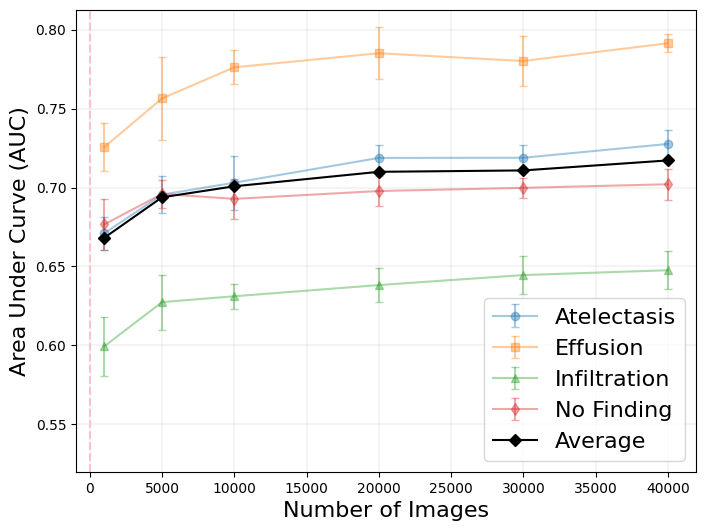

In [3]:
evaluations = {
    key: [
        evaluations11.get(key, (None, None, None)),
        evaluations12.get(key, (None, None, None)),
        evaluations13.get(key, (None, None, None)),
        evaluations14.get(key, (None, None, None)),
        evaluations15.get(key, (None, None, None))
    ]
    for key in sorted(set(evaluations11) | set(evaluations12) | set(evaluations13) | set(evaluations14) | set(evaluations15))
}
# evaluations.pop(50000)

###############

plt.figure(figsize=(8, 6))

aucs_at_means = []
aucs_at_stds = []
aucs_ef_means = []
aucs_ef_stds = []
aucs_in_means = []
aucs_in_stds = []
aucs_nf_means = []
aucs_nf_stds = []
aucs_All_means = []
aucs_All_stds = []
baccs_means = []
baccs_stds = []
accs_means = []
accs_stds = []


for evals_per_epoch in evaluations.values():
    aucs_at = []
    aucs_ef = []
    aucs_in = []
    aucs_nf = []
    baccs = []
    accs = []
    
    for eval in evals_per_epoch:
        aucs_at.append(eval[0][0])
        aucs_ef.append(eval[0][1])
        aucs_in.append(eval[0][2])
        aucs_nf.append(eval[0][3])
        baccs.append(eval[1])
        accs.append(eval[2])

    aucs_at_means.append(np.mean(aucs_at))
    aucs_at_stds.append(np.std(aucs_at))
    aucs_ef_means.append(np.mean(aucs_ef))
    aucs_ef_stds.append(np.std(aucs_ef))
    aucs_in_means.append(np.mean(aucs_in))
    aucs_in_stds.append(np.std(aucs_in))
    aucs_nf_means.append(np.mean(aucs_nf))
    aucs_nf_stds.append(np.std(aucs_nf))
    aucs_All_means.append(np.mean(np.concatenate((aucs_at, aucs_ef, aucs_in, aucs_nf))))
    aucs_All_stds.append(np.std(np.concatenate((aucs_at, aucs_ef, aucs_in, aucs_nf))))
    baccs_means.append(np.mean(baccs))
    baccs_stds.append(np.std(baccs))
    accs_means.append(np.mean(accs))
    accs_stds.append(np.std(accs))
    
average_stds_per_epoch = []
for epoch_stds in zip(aucs_at_stds, aucs_ef_stds, aucs_in_stds, aucs_nf_stds):
    average_stds_per_epoch.append(np.mean(epoch_stds))

print(average_stds_per_epoch)
overall_average_std = np.mean(average_stds_per_epoch)
print(overall_average_std)


x_values = evaluations.keys()

font_size = 16

alpha = 0.4

plt.errorbar(x_values, aucs_at_means, yerr=aucs_at_stds, label='Atelectasis', fmt='-o', capsize=3, alpha=alpha)
plt.errorbar(x_values, aucs_ef_means, yerr=aucs_ef_stds, label='Effusion', fmt='-s', capsize=3, alpha=alpha)
plt.errorbar(x_values, aucs_in_means, yerr=aucs_in_stds, label='Infiltration', fmt='-^', capsize=3, alpha=alpha)
plt.errorbar(x_values, aucs_nf_means, yerr=aucs_nf_stds, label='No Finding', fmt='-d', capsize=3, alpha=alpha)
plt.errorbar(x_values, aucs_All_means, label='Average', marker='D', color='black')

# plt.plot(x_values, aucs_at_means, label='Atelectasis')
# plt.plot(x_values, aucs_ef_means, label='Effusion')
# plt.plot(x_values, aucs_in_means, label='Infiltration')
# plt.plot(x_values, aucs_nf_means, label='No Finding')
# plt.plot(x_values, aucs_All_means, color='black', label='Average')

plt.ylabel("Area Under Curve (AUC)", fontsize=font_size)
plt.xlabel("Number of Images", fontsize=font_size)
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
plt.legend(fontsize=font_size, loc="lower right")
plt.ylim(0.52)

# plt.savefig("evalsNewNew/amount_10000samples_20epochs_5runs.pdf", bbox_inches='tight', pad_inches=0)

plt.show()

In [ ]:
# resnet 2, evaluations performed on same images
evaluations[1000] = [0.5951705342080308, 0.5952834163730929, 0.5491585549328315, 0.5837986844451944]
evaluations[5000] = [0.5891045793542963, 0.6419020893294389, 0.5932313546781207, 0.6190560622572474]
evaluations[10000] = [0.5977691506342, 0.6672470568193952, 0.6073564354674396, 0.6436931798447493]
evaluations[20000] = [0.6059535362545011, 0.6815362382316886, 0.6190353560004435, 0.6531992828088194]

# resnet 3, evaluations performed on same images, but not the same as resnet2 :(  
evaluations[30000] =  [0.6128297799234521, 0.6991612595585637, 0.6171296337469041, 0.6585578429039627]

# kinda sus
evaluations[40000] = [0.6142084909019965, 0.7061184542054836, 0.6202946955119831, 0.6634272764365938]
evaluations[50000] = [0.5155062622458416, 0.4876153303583012, 0.511379121087254, 0.5070106915031427]
evaluations[60000] = [0.575126752123253, 0.5227519864244172, 0.5197165689298335, 0.5424035885100642]


In [ ]:
# resnet_1:  old tests, evaluations not performed on same dataset
evaluations = {}
evaluations[1000] = ([0.6347517730496454, 0.560263266145619, 0.6424682395644283, 0.6507483510908167], 0.25, 0.73)
evaluations[5000] = ([0.5959241754332469, 0.6571598336304219, 0.6033156318082789, 0.6188024627621943], 0.24964387464387464, 0.701)
evaluations[10000] = ([0.6312244872220658, 0.7101869781324388, 0.6127298673918301, 0.6698854245975006], 0.2523671122584372, 0.686)
evaluations[20000] = ([0.6020582204774969, 0.7128244242566022, 0.610687585199883, 0.6665432205589685], 0.2525052174836658, 0.681)
evaluations[30000] = ([0.6247921075166845, 0.6969893081507504, 0.6237814296498461, 0.6710992297176508], 0.25145722510273594, 0.6928333333333333)
evaluations[40000] = ([0.6212903785716848, 0.6931966053864064, 0.6218921292510826, 0.6546177077054522], 0.24991002339391757, 0.694375)
evaluations[50000] = 
evaluations[60000] = 